# Supervised Learning
## Recommenders - Tensorflow Implementation

Author: Bingchen Wang

Last Updated: 11 Sep, 2022

---
<nav>
    <a href="../../Machine%20Learning.ipynb">Machine Learning</a> |
    <a href="../Supervised Learning.ipynb">Supervised Learning</a> |
    <a href="../Recommenders.ipynb">Recommenders</a>
</nav>

---

### Overview

- [Import packages](#IP)
- [Import the MovieLens dataset](#ID)
- [Collaborative filtering](#CF)
    - [Training](#CF_T)
    - [Prediction & Recommendation](#CF_PR)
- [Import the MovieLens dataset](#ID2)
    - [Scale the data properly](#ID2_S)
- [Content-based filtering](#CBF)
    - [Training](#CBF_T)

<a name = "IP"></a>
### Import packages

In [162]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import sklearn.model_selection
import tabulate
import matplotlib.pyplot as plt
import csv

<a name = "ID"></a>
### Import the MovieLens dataset
[Latest MovieLens Dataset](https://grouplens.org/datasets/movielens/latest/)

Clean dataset adapted from: Machine Learning Specialization, Coursera

<table>
    <tr>
        <td>$n_m$</td>
        <td>4778</td>
    </tr>
    <tr>
        <td>$n_u$</td>
        <td>443</td>
    </tr>
</table>

In [7]:
file = open("./data/small_movies_Y.csv", "r")
Y = np.loadtxt(file, delimiter = ",")
file = open("./data/small_movies_R.csv", "r")
R = np.loadtxt(file, delimiter = ",")
movie_list = pd.read_csv("./data/small_movie_list.csv", header = 0, index_col = 0)

In [8]:
# View the data
print("-"*15 + "Y" + "-"*15 )
print(f"Y shape: {Y.shape}")
print(f"Y[:5,:5]:")
print(pd.DataFrame(Y[:5,:5]),"\n")

print("-"*15 + "R" + "-"*15)
print(f"R shape: {R.shape}")
print(f"R[:5,:5]:")
print(pd.DataFrame(R[:5,:5]),"\n")

print("-"*10 + "List of movies" + "-"*10)
print(movie_list[:5])

---------------Y---------------
Y shape: (4778, 443)
Y[:5,:5]:
     0    1    2    3    4
0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0
4  5.0  0.0  0.0  0.0  0.0 

---------------R---------------
R shape: (4778, 443)
R[:5,:5]:
     0    1    2    3    4
0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0
4  1.0  0.0  0.0  0.0  0.0 

----------List of movies----------
   mean rating  number of ratings               title
0     3.400000                  5   Yards, The (2000)
1     3.250000                  6  Next Friday (2000)
2     2.000000                  4    Supernova (2000)
3     2.000000                  4  Down to You (2000)
4     2.672414                 29     Scream 3 (2000)


<a name = "CF"> </a>
### Collaborative filtering
#### Notation
<table>
    <tr>
        <th> Notation </th>
        <th> Dimension </th>
    </tr>
    <tr>
        <td>$\mathbf{W}$</td>
        <td>$n_u \times n$</td>
    </tr>
    <tr>
        <td>$\mathbf{X}$</td>
        <td>$n_m \times n$</td>
    </tr>
    <tr>
        <td>$\mathbf{b}$</td>
        <td>$n_u \times 1$</td>
    </tr> 
    <tr>
        <td>$\mathbf{R}$</td>
        <td>$n_m \times n_u$</td>
    </tr>
    <tr>
        <td>$\mathbf{Y}$</td>
        <td>$n_m \times n_u$</td>
    </tr>    
</table>

#### Cost function
$$
J = \frac{1}{2} \text{tf.reduce_sum} (\mathbf{R} * (\mathbf{X}\mathbf{W}^T + \mathbf{b} - \mathbf{Y})^2) + \frac{\lambda}{2}\left\Vert \mathbf{W} \right\Vert^2 + \frac{\lambda}{2}\left\Vert \mathbf{X} \right\Vert^2
$$

<a name = "CF_T"> </a>
#### Training

In [22]:
# cost function
def cofi_cost_function(W, b, X, R, Y, lambda_):
    cost = 1/2 * tf.reduce_sum(R * (tf.linalg.matmul(X, tf.transpose(W)) + b - Y)**2) + lambda_/2 * tf.linalg.norm(W)**2 + lambda_/2 * tf.linalg.norm(X)**2
    return cost

# initialise variables
def initialise_variables(Y, num_features = 100):
    num_movies, num_users = Y.shape
    W = tf.Variable(tf.random.normal((num_users, num_features)), name = "W")
    b = tf.Variable(tf.random.normal((1, num_users)), name = "b")
    X = tf.Variable(tf.random.normal((num_movies, num_features)), name = "X")
    return W,b,X

def training_cofi(W, b, X, R, Y, optimizer, lambda_ = 1, num_iterations = 200):
    history_training_costs = []
    for i in range(num_iterations):
        # compute cost
        with tf.GradientTape() as tape:
            cost = cofi_cost_function(W, b, X, R, Y, lambda_)
        # compute gradients
        grads = tape.gradient(cost, [W,b,X])
        # apply gradients
        optimizer.apply_gradients(zip(grads, [W,b,X]))
        
        # log the training process
        history_training_costs.append(cost)
        
        # print training information
        print(f"\r Iteration: {i+1}| Training cost: {cost:.2f}", end = "")
        if (i+1) %  (num_iterations//10) == 0:
            print(f"\r Iteration: {i+1}| Training cost: {cost:.2f}")
    return history_training_costs

##### Mean normalization

In [18]:
# Mean normalisation of Y
def normalizeY(Y,R, err = 1e-12):    
    Y_mean = (np.sum(Y*R, axis = 1)/(np.sum(R, axis = 1) + err)).reshape((-1,1))
    Y_norm = Y - Y_mean
    return Y_mean, Y_norm
def denormalizeY(Y_norm, Y_mean):
    return Y_norm + Y_mean

In [23]:
W,b,X = initialise_variables(Y, num_features = 100)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)
Y_mean, Y_norm = normalizeY(Y, R, err = 1e-12)
history_costs = training_cofi(W, b, X, R, Y_norm, optimizer, lambda_ = 1, num_iterations = 1000)

 Iteration: 100| Training cost: 7952.931
 Iteration: 200| Training cost: 2456.77
 Iteration: 300| Training cost: 1946.74
 Iteration: 400| Training cost: 1841.62
 Iteration: 500| Training cost: 1804.15
 Iteration: 600| Training cost: 1786.49
 Iteration: 700| Training cost: 1776.95
 Iteration: 800| Training cost: 1771.41
 Iteration: 900| Training cost: 1768.04
 Iteration: 1000| Training cost: 1765.94


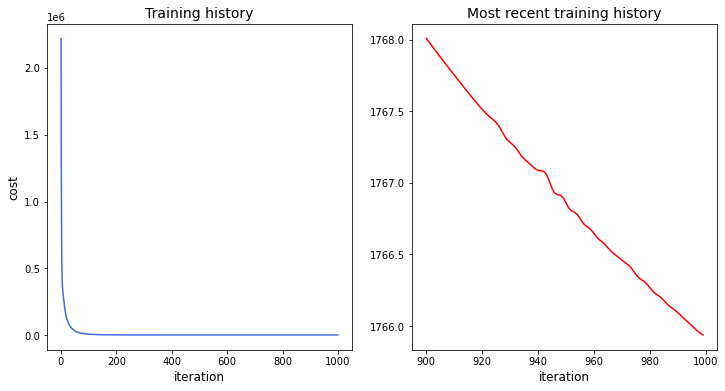

In [37]:
def plot_training_history(history_costs):
    num_iters = len(history_costs)
    lastest_tenth = num_iters*9//10
    fig, axes = plt.subplots(1,2, figsize = (12, 6))
    
    axes[0].plot(np.arange(len(history_costs)), np.array(history_costs), c = "royalblue")
    axes[0].set_xlabel("iteration", fontsize = 12)
    axes[0].set_ylabel("cost", fontsize = 12)
    axes[0].set_title("Training history", fontsize = 14)
    axes[1].plot(np.arange(len(history_costs))[lastest_tenth:], np.array(history_costs)[lastest_tenth:], c = "red")
    axes[1].set_xlabel("iteration", fontsize = 12)
    axes[1].set_title("Most recent training history", fontsize = 14)
plot_training_history(history_costs)

<a name = "CF_PR"> </a>
#### Prediction & Recommendation

In [121]:
def predict_user(w,b,X, Y_mean):
    w = tf.reshape(w, (-1,1))
    return denormalizeY(tf.linalg.matmul(X, w) + b, Y_mean)
def recommend_user(y_user, r_user, movie_list, num_recs = 10, filter_by_num_ratings = True, filter_by_mean_rating = True):
    movie_list = movie_list.copy()
    movie_list["user_pred"] = y_user   
    r_user = r_user.copy()
    movie_list = movie_list.iloc[(1-r_user).astype(bool)]
    if filter_by_num_ratings:
        filter = (movie_list["number of ratings"]>=20)
        movie_list = movie_list.loc[filter]
    if filter_by_num_ratings:
        filter = (movie_list["mean rating"]>=2.5)
        movie_list = movie_list.loc[filter]
    movie_list = movie_list.sort_values("user_pred", ascending=False)
    print(movie_list[:num_recs])

In [125]:
user_id = 3
w_user = W[user_id,:]
b_user = b[:,user_id]
r_user = R[:,user_id]
recommend_user(predict_user(w_user, b_user, X, Y_mean), r_user, movie_list)

      mean rating  number of ratings  \
2804     3.989362                 47   
3014     3.869565                 69   
3862     3.986111                 36   
4527     3.925926                 27   
1743     4.252336                107   
1081     3.803797                 79   
2562     3.677419                 31   
1930     3.862069                 58   
2455     3.887931                 58   
1122     4.006494                 77   

                                                  title  user_pred  
2804  Harry Potter and the Deathly Hallows: Part 1 (...   4.515487  
3014                               Avengers, The (2012)   4.459908  
3862                Kingsman: The Secret Service (2015)   4.387707  
4527                Rogue One: A Star Wars Story (2016)   4.346265  
1743                               Departed, The (2006)   4.340081  
1081                                Spider-Man 2 (2004)   4.309261  
2562                            Blind Side, The  (2009)   4.292416  
1930   

In [170]:
print("="*15 + "data shapes" + "="*15)
print("-"*15 + "y_train" + "-"*15)
print(f"y_train shape: {y_train.shape}")
print(y_train[:10])

print("-"*15 + "user_train" + "-"*15)
print(f"user_train shape: {user_train.shape}")
print(user_headers[:5])
print(user_train[:10,:5])

print("-"*15 + "item_train" + "-"*15)
print(f"item_train shape: {item_train.shape}")
print(item_headers[:5])
print(item_train[:10,:5])

print("-"*15 + "movie_list" + "-"*15)
print(movie_list[:10])

===============data shapes===============
---------------y_train---------------
y_train shape: (46549,)
[4.  4.  3.5 4.  2.  3.5 0.5 3.5 3.5 3. ]
---------------user_train---------------
user_train shape: (46549, 17)
['user id', 'rating count', 'rating ave', 'Action', 'Adventure']
[[520.          41.           3.84146341   3.86111111   3.9047619 ]
 [460.          41.           4.36585366   4.39285714   4.53333333]
 [466.          73.           3.95205479   3.8          3.95454545]
 [551.          58.           3.52586207   3.55555556   3.46551724]
 [ 28.         145.           2.9137931    2.96610169   3.07142857]
 [560.         202.           3.5049505    3.5          3.3877551 ]
 [ 22.          69.           2.10869565   2.6875       1.97058824]
 [305.         243.           3.90534979   3.785        3.71969697]
 [119.         114.           4.20175439   4.20238095   4.15      ]
 [ 68.         371.           3.4083558    3.37218045   3.53465347]]
---------------item_train------------

<a name = "ID2"></a>
### Import the MovieLens dataset II


In [163]:
# data
with open("./data2/content_y_train.csv", "r") as file:
    y_train = np.loadtxt(file, delimiter = ",")
with open("./data2/content_user_train.csv", "r") as file:
    user_train = np.loadtxt(file, delimiter = ",")
with open("./data2/content_item_train.csv", "r") as file:
    item_train = np.loadtxt(file, delimiter = ",")
movie_list = pd.read_csv("./data2/content_movie_list.csv", header = 0, index_col = 0)

# split the data into the training and dev sets
y_train, y_dev = sklearn.model_selection.train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
user_train, user_dev = sklearn.model_selection.train_test_split(user_train,    train_size=0.80, shuffle=True, random_state=1)
item_train, item_dev = sklearn.model_selection.train_test_split(item_train,    train_size=0.80, shuffle=True, random_state=1)

# headers
with open("./data2/content_user_train_header.txt", "r") as file:
    user_headers = list(csv.reader(file))[0]
    
with open("./data2/content_item_train_header.txt", "r") as file:
    item_headers = list(csv.reader(file))[0]

<a name = "ID2_S"></a>
#### Scale the data properly
<div class = "alert alert-block alert-danger"><b>Note:</b> Scaling $\mathbf{X}$ is necessary for the optimisation to converge.</div>

In [185]:
# user input normalization
user_scaler = sklearn.preprocessing.StandardScaler()
user_scaler.fit(user_train)
user_train = user_scaler.transform(user_train)
user_dev = user_scaler.transform(user_dev)

# item input normalization
item_scaler = sklearn.preprocessing.StandardScaler()
item_scaler.fit(item_train)
item_train = user_scaler.transform(item_train)
item_dev = user_scaler.transform(item_dev)


# y normalization
y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)) 
y_scaler.fit(y_train.reshape(-1,1))
y_norm_train = y_scaler.transform(y_train.reshape(-1,1))
y_norm_dev = y_scaler.transform(y_dev.reshape(-1,1))

<a name = "CBF"></a>
### Content-based filtering

#### Cost function
$$
J(\mathbf{W}, \mathbf{b})= \sum_{j=0}^{n_u-1} \sum_{i=0}^{n_m-1}r(i,j)*(\mathbf{v}_u^{(j)} \cdot \mathbf{v}_m^{(i)} - y^{(i,j)})^2
+\text{regularisation of neural networks weights}
$$

<a name = "CBF_T"></a>
#### Training

In [200]:
# cost function
cbfi_cost_function = tf.keras.losses.MeanSquaredError()

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

# initialise the variables and model
def initialise_cbfi(num_user_features, num_movie_features, num_features = 32):
    User_NN = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation = "relu"),
        tf.keras.layers.Dense(128, activation = "relu"),
        tf.keras.layers.Dense(units = num_features, activation = "linear")
    ])
    Movie_NN = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation = "relu"),
        tf.keras.layers.Dense(128, activation = "relu"),
        tf.keras.layers.Dense(units = num_features, activation = "linear")
    ])
    
    input_user = tf.keras.layers.Input(shape = (num_user_features))
    V_u = User_NN(input_user)
    # Normalize the result as y_norm is between -1 and 1
    V_u = tf.linalg.l2_normalize(V_u, axis = 1)
    
    input_movie = tf.keras.layers.Input(shape = (num_movie_features))
    V_m = Movie_NN(input_movie)
    # Normalize the result as y_norm is between -1 and 1
    V_m = tf.linalg.l2_normalize(V_m, axis = 1)
    
    output = tf.keras.layers.Dot(axes = 1)([V_u,V_m])
    
    model = tf.keras.models.Model([input_user, input_movie], output)
    
    return User_NN, Movie_NN, model

In [201]:
print(f"Number of user features: {len(user_headers[3:])}")
print(f"Number of item features: {len(item_headers[1:])}")
User_NN, Movie_NN, cbfi_model = initialise_cbfi(len(user_headers[3:]), len(item_headers[1:]), num_features = 32)
cbfi_model.summary()
cbfi_model.compile(optimizer=optimizer,
              loss=cbfi_cost_function)

Number of user features: 14
Number of item features: 16
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 14)]         0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 16)]         0           []                               
                                                                                                  
 sequential_23 (Sequential)     (None, 32)           40864       ['input_23[0][0]']               
                                                                                                  
 sequential_24 (Sequential)     (None, 32)           41376       ['input_24[0][0]']               
                                    

In [188]:
cbfi_model.fit([user_train[:,3:], item_train[:,1:]], y_norm_train, epochs = 30)

Epoch 1/30
1455/1455 [==============================] - 4s 2ms/step - loss: 0.1279
Epoch 2/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1186
Epoch 3/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1171
Epoch 4/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1157
Epoch 5/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1146
Epoch 6/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1140
Epoch 7/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1134
Epoch 8/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1128
Epoch 9/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1122
Epoch 10/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1116
Epoch 11/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1113
Epoch 12/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1107
E

In [189]:
cbfi_model.evaluate([user_dev[:, 3:], item_dev[:, 1:]], y_norm_dev)

364/364 [==============================] - 1s 1ms/step - loss: 0.1085


0.10845358669757843

#### Pre-training movie feature vectors

In [197]:
with open("./data2/content_item_vecs.csv", "r") as file:
    item_vecs = np.loadtxt(file, delimiter = ",")
    
print(f"Number of movies: {item_vecs.shape[0]}")
print(f"Number of input features for each movie: {item_vecs.shape[1]}")
print(item_vecs[0])

scaled_item_vecs = item_scaler.transform(item_vecs)
print(scaled_item_vecs[0])

Number of movies: 1883
Number of input features for each movie: 17
[4.05400e+03 2.00100e+03 2.84375e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
[-0.88982143 -1.12286669 -1.74726552 -0.37092977 -0.34542167 -0.18866875
 -0.18472541 -0.40146037 -0.26456297 -0.06747961  2.45484504 -0.24302899
 -0.14356172 -0.18781227 -0.26664864 -0.27288076 -0.3484917 ]


In [202]:
# item model
input_item_model = tf.keras.layers.Input(shape = len(item_headers[1:]))
vm_model = Movie_NN(input_item_model)
vm_model = tf.linalg.l2_normalize(vm_model, axis = 1)
item_model = tf.keras.models.Model(input_item_model, vm_model)

In [204]:
vm_pred = item_model.predict(scaled_item_vecs[:,1:])

59/59 [==============================] - 0s 1ms/step


In [208]:
print(f"Shape of all predicted movie feature vectors: {vm_pred.shape}")

Shape of all predicted movie feature vectors: (1883, 32)


In [209]:
# Define the distance function
def sq_dist(v1,v2):
    return np.linalg.norm(v1-v2, ord = 2)**2

In [210]:
# Display a sample of similar movies
count = 25
dim = len(vm_pred)
distances_movies = np.zeros((dim, dim))
for i in range(dim):
    for j in range(dim):
        distances_movies[i,j] = sq_dist(vm_pred[i], vm_pred[j])
print(distances_movies[:5,:5])

[[0.00000000e+00 1.11751623e+00 1.21505567e+00 1.13801518e+00
  6.07556425e-01]
 [1.11751623e+00 0.00000000e+00 1.63824765e+00 1.34375299e-03
  1.19167788e+00]
 [1.21505567e+00 1.63824765e+00 0.00000000e+00 1.64927760e+00
  8.45420938e-01]
 [1.13801518e+00 1.34375299e-03 1.64927760e+00 0.00000000e+00
  1.19419443e+00]
 [6.07556425e-01 1.19167788e+00 8.45420938e-01 1.19419443e+00
  0.00000000e+00]]


In [211]:
masked_distances = np.ma.masked_array(distances_movies, mask = np.identity(dim))
print(masked_distances[:5,:5])

[[-- 1.1175162316129814 1.215055671637458 1.1380151830099408
  0.6075564250288643]
 [1.1175162316129814 -- 1.6382476475848904 0.0013437529890248379
  1.1916778799388794]
 [1.215055671637458 1.6382476475848904 -- 1.6492776017856983
  0.8454209381621105]
 [1.1380151830099408 0.0013437529890248379 1.6492776017856983 --
  1.1941944298998806]
 [0.6075564250288643 1.1916778799388794 0.8454209381621105
  1.1941944298998806 --]]


In [244]:
# Generate a movie dictionary for the ease of display
movie_dict = {}
for i in range(len(movie_list)):
    movie_id = int(movie_list.iloc[i].name)
    movie_dict[movie_id] = {"title": movie_list.iloc[i][0], "genre": movie_list.iloc[i][1]}

# Generate the display table
display = []
for i in range(count):
    movie_id = int(item_vecs[i][0])
    min_idx = np.argmin(masked_distances[i])
    closest_movie_id = int(item_vecs[min_idx][0])
    display.append([movie_dict[movie_id]["title"], movie_dict[movie_id]["genre"],
                    movie_dict[closest_movie_id]["title"], movie_dict[closest_movie_id]["genre"]])
pd.DataFrame(display, columns = ["title", "genre", "closest movie", "genre"])

,title,genre,closest movie,genre
0,Save the Last Dance (2001),Drama|Romance,Planet of the Apes (2001),Action|Adventure|Drama|Sci-Fi
1,Save the Last Dance (2001),Drama|Romance,"Wedding Planner, The (2001)",Comedy|Romance
2,"Wedding Planner, The (2001)",Comedy|Romance,Spy Kids (2001),Action|Adventure|Children|Comedy
3,"Wedding Planner, The (2001)",Comedy|Romance,Save the Last Dance (2001),Drama|Romance
4,Hannibal (2001),Horror|Thriller,"Mothman Prophecies, The (2002)",Drama|Fantasy|Horror|Mystery|Thriller
5,Hannibal (2001),Horror|Thriller,15 Minutes (2001),Thriller
6,Saving Silverman (Evil Woman) (2001),Comedy|Romance,Cats & Dogs (2001),Children|Comedy
7,Saving Silverman (Evil Woman) (2001),Comedy|Romance,Save the Last Dance (2001),Drama|Romance
8,Down to Earth (2001),Comedy|Fantasy|Romance,Joe Dirt (2001),Adventure|Comedy|Mystery|Romance
9,Down to Earth (2001),Comedy|Fantasy|Romance,Queen of the Damned (2002),Fantasy|Horror


#### Recommendation

In [257]:
def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict maxtrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (num_items, 1))
    return(user_vecs)

user_vecs = gen_user_vecs(user_train[0],len(item_vecs))
# Note that user_train has already been scaled properly.

print("Before np.tile():", user_train[0].shape)
print("After np.tile():", user_vecs.shape)

predictions = y_scaler.inverse_transform(cbfi_model.predict([user_vecs[:,3:], scaled_item_vecs[:,1:]]))

Before np.tile(): (17,)
After np.tile(): (1883, 17)
59/59 [==============================] - 0s 2ms/step


In [292]:
num_recs = 10
idx_order = np.argsort(-predictions, axis = 0)
user_recs = np.array([[]])
count = 0

while len(user_recs) != num_recs:
    idx = idx_order[count]
    movie_id = int(item_vecs[idx,0])
    if user_recs.size == 0:
        user_recs = np.array([[np.squeeze(predictions[idx]), movie_id, movie_dict[movie_id]["title"], movie_dict[movie_id]["genre"]]])
    elif str(movie_id) not in user_recs[:,1]:
        user_recs = np.append(user_recs, [[np.squeeze(predictions[idx]), movie_id, movie_dict[movie_id]["title"], movie_dict[movie_id]["genre"]]], axis = 0)
    count += 1
        
pd.DataFrame(user_recs, columns = ["user predicted rating","movie_id", "title","genre"])

,user predicted rating,movie_id,title,genre
0,3.2238162,135536,Suicide Squad (2016),Action|Crime|Sci-Fi
1,3.1998038,122924,X-Men: Apocalypse (2016),Action|Adventure|Fantasy|Sci-Fi
2,3.1990917,179819,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi
3,3.1985528,114180,"Maze Runner, The (2014)",Action|Mystery|Sci-Fi
4,3.198065,111360,Lucy (2014),Action|Sci-Fi
5,3.1476471,117529,Jurassic World (2015),Action|Adventure|Drama|Sci-Fi|Thriller
6,3.1447122,5618,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy
7,3.114598,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
8,3.1100085,84954,"Adjustment Bureau, The (2011)",Romance|Sci-Fi|Thriller
9,3.1061842,84772,Paul (2011),Adventure|Comedy|Sci-Fi
